In [8]:
import math
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload  
import support
reload(support)

class Simulate:
    N,m,n,r,k=200,40,25,2,4
    alpha_infected,alpha_recovered,beta_recovered,beta_death,gamma =0.01, 0, 0.05, 0.005, 0.075
    def __init__(self,m=m,n=n,r=r,k=k,alpha_infected=0.01,alpha_recovered=0,beta_recovered=0.05,beta_death=0.005,gamma=gamma,N=100):
        #check validiy of parameters
        support.parameter_check(m,n,r,k,alpha_infected,alpha_recovered,beta_recovered,beta_death,gamma,N)
        #set up instances attributes for class
        self.m, self.n, self.r,self.k=m,n,r,k
        self.alpha_infected,self.alpha_recovered=alpha_infected,alpha_recovered
        self.beta_recovered,self.beta_death,self.gamma,self.N=beta_recovered,beta_death,gamma,N
        
        #initialize status of all individual, "I", "S","R" or "D"
        self.Status=support.initilize_state(m,n,alpha_infected,alpha_recovered)
        #initialize contact graph
        self.Contact_Graph=support.contact_graph(self.m,self.n,self.r,self.k) 
        
        # initialize atribute Status_History in order to accumulate daily status
        self.Status_History=[self.Status.copy()] #include initial disease status of individuals
    
    @staticmethod
    def State_Summary_Nday(list_of_daily_state):
        """list_of_daily_state: a list contain N+1 dataframe, each dataframe contain disease status of all individual
                in a day (include initial status(day 0) then there are N+1 elements)
            State_Summary_Nday: count how many people who are R, I, S, D in each element of list_of_daily_state then add
                to a row of dataframe status_summary, finally return that dataframe
        """
        status_summary=pd.DataFrame(columns=["Day","S","I","R","D"],dtype=int)
        d=-1
        for s in list_of_daily_state:
            to_np=s.to_numpy()
            to_list=list(to_np.reshape(to_np.shape[0] * to_np.shape[1]))
            R=sum([item=="R" for item in to_list])
            S=sum([item=="S" for item in to_list])
            I=sum([item=="I" for item in to_list])
            D=sum([item=="D" for item in to_list])
            d=d+1
            #add summary data of day d to daily_status dataframe
            status_summary=status_summary.append({"Day":d,"S":S,"R":R,"I":I,"D":D},ignore_index=True)
        return status_summary
    @staticmethod
    def draw(df):
        """df: dataframe which show number of people who are I, R, S,D over N days
           draw: create line chart to present number of patient in each category over time 
        """
        #convert df to long format
        df_long=df.melt(id_vars="Day",var_name="Type",value_name="Number")
        
        df_long['Type'] = df_long['Type'].map({'S': 'Susceptible', 'I':'Infected','R':'Recovered','D':'Dead'})
        palette={"Dead":"black","Recovered":"green","Susceptible":"y","Infected":"magenta"}
        hue_order=["Susceptible","Infected","Recovered","Dead"]
        sns.relplot("Day","Number",kind="line",hue="Type",data=df_long,palette=palette,hue_order=hue_order)
    
    #--------------------------run method-------------------------------------------------------------------
    def run(self):
        self.Status_History=support.Sim_Nday(self.N,self.Status,self.Contact_Graph,self.gamma,self.beta_recovered,self.beta_death)
    
    #--------------------------plot_state method------------------------------------------------------------
    def plot_state(self,d): 
        """d: day that need to present disease status of individuals
           plot_state: draw points which indicate individual addresses and draw lines which connect between two people in contact
        """
        if not(isinstance(d,int)):
            raise ValueError("d must be an integer")
        if (d<0) or (d>self.N):
            raise ValueError(f"d must be between 0 and {self.N}")
        
        #create dataframe grid with three columns: Row, Col are coordinates of a person, and Type is disease status
        grid=pd.DataFrame(columns=["Row","Col","Type"])
        for i in range(self.m):
            for j in range(self.n):
                grid=grid.append({"Row":i,"Col":j,"Type":self.Status_History[d].iloc[i,j]},ignore_index=True)
        
        #preparation for scatter plot
        grid['Type'] = grid['Type'].map({'S': 'Susceptible', 'I':'Infected','R':'Recovered','D':'Dead'})
        palette={"Dead":"black","Recovered":"green","Susceptible":"y","Infected":"magenta"}  #determine color for each state
        hue_order=["Susceptible","Infected","Recovered","Dead"]                              #determine order of legend in plot
        sns.relplot("Row","Col",hue="Type",data=grid,s=26,palette=palette,hue_order=hue_order)
        
        #connect lines between contact pairs
        for pair in self.Contact_Graph:
            p1=pair[0]
            p2=pair[1]
            row=[p1[0],p2[0]]
            col=[p1[1],p2[1]]
            plt.plot(row,col,lw=0.5,color="grey")
        fig = plt.gcf()
        fig.set_size_inches( 12,6)
    #----------------------------chart method------------------------------------------------------------------        
    def chart(self): 
        """draw line chart to present changes in number of people who are I, R, S, D over N days"""
        Simulate.draw(self.Summary_Ndays_Data())
 
    def Summary_Ndays_Data(self):  
        """return a list with length N days+1, which element is a dataframe which indicates disease status of each person in a day"""
        return Simulate.State_Summary_Nday(self.Status_History)
    
    def max_infected(self):
        summary_data=self.Summary_Ndays_Data()
        return max(summary_data["I"])
    
    def peak_infected(self):
        summary_data=self.Summary_Ndays_Data()
        return summary_data["I"].idxmax()
       
    @classmethod
    def average_chart(cls,N_sim=50):
        graph=support.contact_graph(cls.m,cls.n,cls.r,cls.k)  #get contact_graph
        Max_Infected=[]  #initialize list of max infected number of each iterate
        Peak_Infected=[] #initialize list of peak infect date of each iterate
        #pd.DataFrame(0, index=range(3), columns=[])
        N_Sim_Data=pd.DataFrame(0,index=range(cls.N),columns=["Day","S","I","R","D"])
        for t in range(N_sim):
            initial_status=support.initilize_state(cls.m,cls.n,cls.alpha_infected,cls.alpha_recovered) #initialize disease at each iterate
            sim_data_nday=support.Sim_Nday(cls.N,initial_status,graph,cls.gamma,cls.beta_recovered,cls.beta_death) #simulated data for N days
            Summary_Nday=Simulate.State_Summary_Nday(sim_data_nday)  #summary simulated data of N days (each day how many infected,susceptible...)
            Max_Infected.append(max(Summary_Nday["I"]))
            Peak_Infected.append(Summary_Nday["I"].idxmax())
            N_Sim_Data=N_Sim_Data+Summary_Nday  #add up data after each iterate for calculating average later  
        Simulate.draw(N_Sim_Data/N_sim)  #draw a line chart to present daily average number over N days period
        
        return {"Avg Max_Infected":sum(Max_Infected)/len(Max_Infected),"Avg Peak_Infected":sum(Peak_Infected)/len(Peak_Infected)}
                       

In [9]:
s=Simulate(N=200)
s.run()

In [10]:
s.max_infected()

208

In [11]:
s.peak_infected()

47

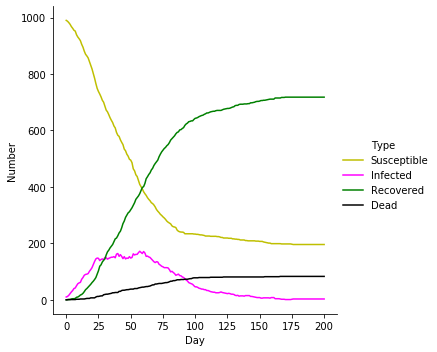

In [5]:
s.chart()

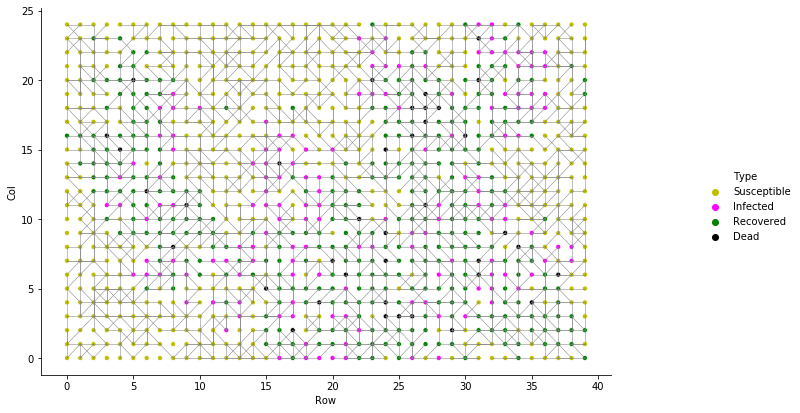

In [6]:
s.plot_state(50)

{'Avg Max_Infected': 185.05, 'Avg Peak_Infected': 50.25}

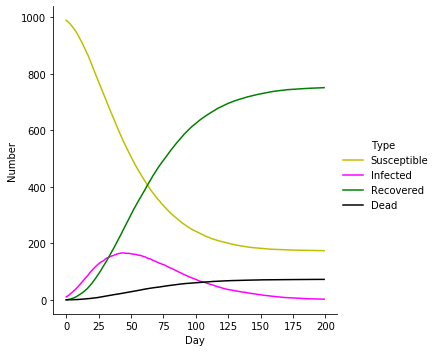

In [7]:
Simulate.average_chart(40)